## Projeto Detecção de Fraude de Cartão de Crédito ( PIX?)

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('default')
import sklearn 
import imblearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import datetime 

import os
import gc as GarbageCollector

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_fscore_support, roc_auc_score

##### Reading Data

In [2]:
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

## merge the datasets

data = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
data.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


##### Fixing Dates

In [3]:
def fix_dates(df):
    
    # create date column
    START_DATE = '2017-12-01' # found this start date from commets 
    
    # required START_DATE since DT is a time delta from start
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    df['hour']  = df['TransactionDT'].dt.hour
    df['day']   = df['TransactionDT'].dt.day
    df['dow']   = df['TransactionDT'].dt.dayofweek
    df['month'] = df['TransactionDT'].dt.month
    df['year']  = df['TransactionDT'].dt.year
    
    df.drop(columns=['TransactionDT'], inplace=True)
    
    return df

data = fix_dates(data)

##### Saving Data Required for Submission

In [4]:
# ground truth
truth = data['isFraud']
#data.drop(columns=['isFraud'], inplace=True)

## TransactionIDs for Test
data_trans_id  = pd.DataFrame({'TransactionID': data.index})

In [5]:
# ground truth
#X = data['isFraud']
#data.drop(columns=['isFraud'], inplace=True)

## TransactionIDs for Test
#data_trans_id  = pd.DataFrame({'TransactionID': data.index})

### Preprocessing

##### Removal of columns with too much missing data

In [6]:
# constants
data_columns = data.columns
MISSING_TOL = 0.5

# remove columns that dont matter
one_value_cols      = [col for col in data_columns if data[col].nunique() <= 1]

# remove columns with too many null values
many_null_cols      = [col for col in data_columns if data[col].isnull().sum() / data.shape[0] > MISSING_TOL]

# drop
cols_to_rm = list(set(one_value_cols + many_null_cols))

data.drop(cols_to_rm, axis=1, inplace=True, errors='ignore')


In [7]:
del train_transaction, train_identity
GarbageCollector.collect()

data.shape

(590540, 224)

##### Replace Numerical Missings with Median

In [8]:
# Define List of Cat Features

cards = [f'card{i}' for i in range(1, 7)]
addrs = [f'addr{i}' for i in range(1, 3)]
email = ['P_emaildomain', 'R_emaildomain']
M     = [f'M{i}' for i in range(1, 10)]

identity = ['DeviceType', 'DeviceInfo']
ids = [f'id_{i}' for i in range(12, 39)]

# combine all features
__columns = data.columns.tolist()
cat_features = ['ProductCD'] + cards + addrs + email + M + identity + ids
cat_features_present = [feature for feature in cat_features if feature in __columns]

In [9]:
# Find Medians and Replace

num_features = set(data.columns) - set(cat_features_present) 
num_features = list(num_features)

medians = data[num_features].median()

data.fillna(medians, inplace=True)

In [10]:
# Tag missing Categorical Features and Apply LabelEncoder

from sklearn.preprocessing import LabelEncoder

for c in cat_features_present:
    data[c] = data[c].fillna("missing")

In [11]:
from pandas.api.types import CategoricalDtype
categorical_values = {}

for c in cat_features_present:
    # convert to categorical feature
    data[c] = data[c].astype("category")
    
    # added a unknown to help convert test set categories
    #data[c].cat.add_categories('unknown', inplace=True)
    
    # save all categories defined in test columns
    #categorical_values[c] = data[c].cat.categories
       
# label encoding !
for c in cat_features_present:
    data[c] = data[c].cat.codes

In [12]:
data.head()

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V317,V318,V319,V320,V321,hour,day,dow,month,year
0,2987000,0,68.5,4,10095,500,42,1,38,1,...,117.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
1,2987001,0,29.0,4,1372,303,42,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
2,2987002,0,59.0,4,2833,389,42,4,58,2,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017
3,2987003,0,50.0,4,13341,466,42,2,14,2,...,1404.0,790.0,0.0,0.0,0.0,0,2,5,12,2017
4,2987004,0,50.0,1,2712,413,42,2,2,1,...,0.0,0.0,0.0,0.0,0.0,0,2,5,12,2017


In [13]:
# Checagem das colunas
data.columns[:-1].values

array(['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'V1', 'V2',
       'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39',
       'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48',
       'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57',
       'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66',
       'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75',
       'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84',
       'V85

### Analisando os dados

Há várias técnicas que você pode utilizar para lidar com desbalanceamento de dados. Algumas das técnicas mais comuns incluem:

Oversampling: consiste em criar cópias das instâncias da classe minoritária para aumentar a sua representatividade no conjunto de dados.

Undersampling: consiste em remover aleatoriamente instâncias da classe majoritária para diminuir a sua representatividade no conjunto de dados.

Synthetic Minority Over-sampling Technique (SMOTE): essa técnica cria novas instâncias sintéticas da classe minoritária através da combinação linear de instâncias existentes.

Adição de peso às classes: consiste em adicionar um peso maior à classe minoritária no cálculo da função de custo do modelo.

Ensemble de modelos: pode-se utilizar técnicas de ensemble para combinar vários modelos que foram treinados em subconjuntos do conjunto de dados. Essa técnica pode melhorar o desempenho do modelo em problemas de desbalanceamento.

Mudança da métrica de avaliação: em vez de utilizar métricas como acurácia, pode-se utilizar outras métricas que levam em conta o desbalanceamento do conjunto de dados, como F1-score, AUC-ROC, entre outras.

Essas são apenas algumas das técnicas que podem ser utilizadas para lidar com desbalanceamento de dados. A escolha da técnica mais apropriada depende do problema em questão e da disponibilidade de dados. É importante avaliar o desempenho do modelo em diferentes técnicas para determinar qual delas é a mais adequada para o seu problema.

###  Note que a normalização dos dados é opcional, mas é recomendável para muitos modelos de aprendizagem de máquina. A conversão das colunas de tipo objeto para categórico também é opcional, mas pode ser benéfico para alguns modelos.





<AxesSubplot:xlabel='isFraud', ylabel='count'>

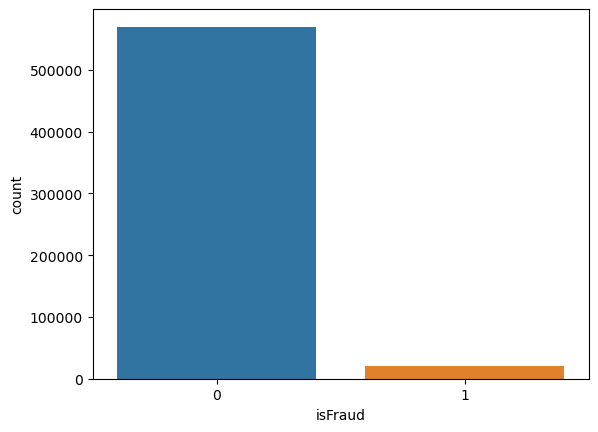

In [14]:
sns.countplot(x='isFraud', data=data)

In [15]:
# Contagem de grupos
data.groupby(by=['isFraud'])['isFraud'].count()

isFraud
0    569877
1     20663
Name: isFraud, dtype: int64

## Calcular a importância das características: Vamos usar o método de árvore de decisão para calcular a importância das características.

In [16]:
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [17]:
#instanciar o classificador da árvore de decisão
tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X, y)

#calculando a importância das características
importances = tree_clf.feature_importances_

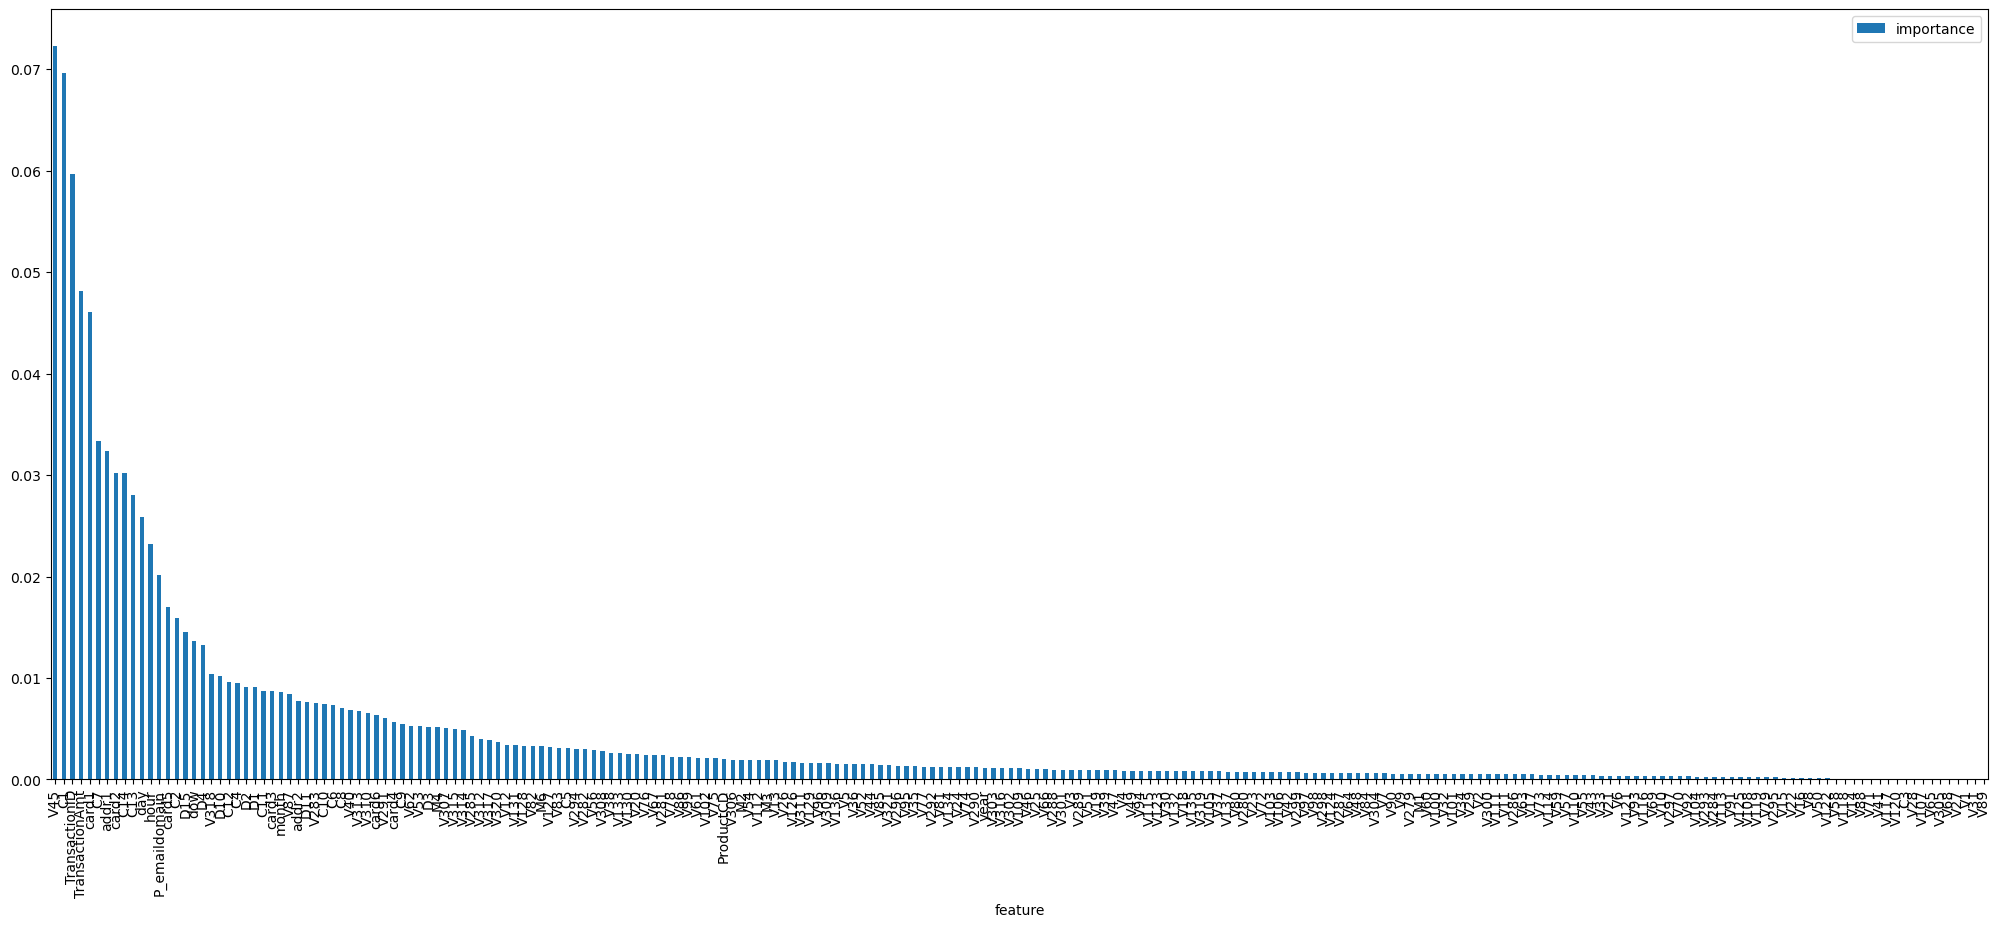

In [18]:
importances_df = pd.DataFrame({'feature': X.columns, 'importance': importances})

importances_df = importances_df.sort_values('importance', ascending=False).set_index('feature')

plt.rcParams['figure.figsize'] = (25, 10)
importances_df.plot.bar();

##  Selecionar as características: Vamos selecionar as características com as maiores importâncias.

In [19]:
#selecionar as características com as maiores importâncias
selected_features = X.columns[importances > 0.01]

#criação de um novo conjunto de dados apenas com as características selecionadas
X_selected = X[selected_features]

In [20]:
X_selected

,TransactionID,TransactionAmt,card1,card2,card5,addr1,P_emaildomain,C1,C2,C7,C13,C14,D4,D10,D15,V45,V318,hour,day,dow
0,2987000,68.50,10095,500,38,166,31,1.0,1.0,0.0,1.0,1.0,26.0,13.0,0.0,1.0,0.0,0,2,5
1,2987001,29.00,1372,303,2,173,16,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2,5
2,2987002,59.00,2833,389,58,178,36,1.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,0.0,0,2,5
3,2987003,50.00,13341,466,14,282,54,2.0,5.0,0.0,25.0,1.0,94.0,84.0,111.0,1.0,790.0,0,2,5
4,2987004,50.00,2712,413,2,241,16,1.0,1.0,0.0,1.0,1.0,26.0,15.0,52.0,1.0,0.0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,49.00,4305,500,108,132,31,2.0,1.0,0.0,3.0,2.0,26.0,56.0,56.0,1.0,0.0,23,1,4
590536,3577536,39.50,7354,124,106,78,16,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,23,1,4
590537,3577537,30.95,8621,494,106,98,16,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,23,1,4
590538,3577538,117.00,5297,380,106,219,2,1.0,1.0,0.0,5.0,1.0,22.0,22.0,22.0,1.0,0.0,23,1,4


In [21]:
# Converter o array numpy de volta em um dataframe pandas
X_selected = pd.DataFrame(X_selected, columns=selected_features)

In [22]:
X_selected = X_selected.reset_index(drop=True)

In [23]:
X_selected

,TransactionID,TransactionAmt,card1,card2,card5,addr1,P_emaildomain,C1,C2,C7,C13,C14,D4,D10,D15,V45,V318,hour,day,dow
0,2987000,68.50,10095,500,38,166,31,1.0,1.0,0.0,1.0,1.0,26.0,13.0,0.0,1.0,0.0,0,2,5
1,2987001,29.00,1372,303,2,173,16,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2,5
2,2987002,59.00,2833,389,58,178,36,1.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,0.0,0,2,5
3,2987003,50.00,13341,466,14,282,54,2.0,5.0,0.0,25.0,1.0,94.0,84.0,111.0,1.0,790.0,0,2,5
4,2987004,50.00,2712,413,2,241,16,1.0,1.0,0.0,1.0,1.0,26.0,15.0,52.0,1.0,0.0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,49.00,4305,500,108,132,31,2.0,1.0,0.0,3.0,2.0,26.0,56.0,56.0,1.0,0.0,23,1,4
590536,3577536,39.50,7354,124,106,78,16,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,23,1,4
590537,3577537,30.95,8621,494,106,98,16,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,23,1,4
590538,3577538,117.00,5297,380,106,219,2,1.0,1.0,0.0,5.0,1.0,22.0,22.0,22.0,1.0,0.0,23,1,4


In [24]:
y.shape

(590540,)

In [25]:
# Converter a série y em DataFrame
y_df = pd.DataFrame(y, columns=["isFraud"])

In [26]:
y_df

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
590535,0
590536,0
590537,0
590538,0


In [27]:
y_df = y_df.reset_index(drop=True)

In [28]:
y_df

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
590535,0
590536,0
590537,0
590538,0


## new data é o novo dataframe com os X(features) importantes selecionados e y ( a classe)

In [29]:
# Concatenar os DataFrames X_selected e y_df
new_data = pd.concat([X_selected, y_df], axis=1)

In [30]:
new_data

,TransactionID,TransactionAmt,card1,card2,card5,addr1,P_emaildomain,C1,C2,C7,...,C14,D4,D10,D15,V45,V318,hour,day,dow,isFraud
0,2987000,68.50,10095,500,38,166,31,1.0,1.0,0.0,...,1.0,26.0,13.0,0.0,1.0,0.0,0,2,5,0
1,2987001,29.00,1372,303,2,173,16,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0,2,5,0
2,2987002,59.00,2833,389,58,178,36,1.0,1.0,0.0,...,1.0,0.0,0.0,315.0,1.0,0.0,0,2,5,0
3,2987003,50.00,13341,466,14,282,54,2.0,5.0,0.0,...,1.0,94.0,84.0,111.0,1.0,790.0,0,2,5,0
4,2987004,50.00,2712,413,2,241,16,1.0,1.0,0.0,...,1.0,26.0,15.0,52.0,1.0,0.0,0,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,49.00,4305,500,108,132,31,2.0,1.0,0.0,...,2.0,26.0,56.0,56.0,1.0,0.0,23,1,4,0
590536,3577536,39.50,7354,124,106,78,16,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,23,1,4,0
590537,3577537,30.95,8621,494,106,98,16,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,23,1,4,0
590538,3577538,117.00,5297,380,106,219,2,1.0,1.0,0.0,...,1.0,22.0,22.0,22.0,1.0,0.0,23,1,4,0


## OVERSAMPLING(SMOTE)

Se o oversampling for feito antes da validação cruzada, o oversampling da classe minoritária pode resultar em um problema de overfitting.

Erro de sobreajuste de validação cruzada:

Overfitting durante a validação cruzada:
Em nossa análise de subamostra, quero mostrar um erro comum que cometi e que quero compartilhar com todos vocês. É simples, se você deseja subamostrar ou superamostrar seus dados, não deve fazê-lo antes da validação cruzada. Porque você estará influenciando diretamente o conjunto de validação antes de implementar a validação cruzada, causando um problema de "vazamento de dados". Na seção a seguir, você verá pontuações surpreendentes de precisão e recuperação, mas, na realidade, nossos dados estão superajustados!

O caminho errado:

Como mencionado anteriormente, se pegarmos a classe minoritária ("Fraude") em nosso caso, e criarmos os pontos sintéticos antes da validação cruzada, teremos uma certa influência no "conjunto de validação" do processo de validação cruzada. Lembre-se de como funciona a validação cruzada, vamos suponha que estamos dividindo os dados em 5 lotes, 4/5 do conjunto de dados será o conjunto de treinamento enquanto 1/5 será o conjunto de validação. O conjunto de teste não deve ser tocado! Por esse motivo, temos que fazer a criação de pontos de dados sintéticos "durante" a validação cruzada e não antes, como abaixo:

A Maneira Certa:

Como você pode ver acima, o SMOTE ocorre "durante" a validação cruzada e não "antes" do processo de validação cruzada. Os dados sintéticos são criados apenas para o conjunto de treinamento sem afetar o conjunto de validação.

In [31]:
from collections import Counter
import time

In [32]:
# Dividir os dados em features e labels
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [34]:
# Imprime a quantidade de classes 0 e 1 antes do SMOTE
print('Antes do SMOTE:', Counter(y_train))

Antes do SMOTE: Counter({0: 455902, 1: 16530})


## Regressão Logística

In [35]:
start_time = time.time()
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

In [35]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [37]:
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [38]:
#grid_search.fit(X_train, y_train)
#lr_mean_score = grid_search.best_score_
#test_score = grid_search.score(X_test, y_test)
#print(f'Cross-validation score: {lr_mean_score}\nTest score: {test_score}')

In [39]:
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
y_pred_lr = grid_search.predict(X_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.8063668511980501
Test score: 0.8024502000732712


In [40]:
print("Melhores parâmetros: ", grid_search.best_params_)
print("Melhores hiper-parâmetros: ", grid_search.best_estimator_)
print("Melhor pontuação de validação cruzada: ", cv_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

Melhores parâmetros:  {'classifier__C': 10}
Melhores hiper-parâmetros:  Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', MinMaxScaler()),
                ['classifier',
                 LogisticRegression(C=10, max_iter=1000, random_state=11)]])
Melhor pontuação de validação cruzada:  0.8063668511980501
--- 26 minutes 49 seconds ---


In [41]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92    113975
           1       0.13      0.59      0.21      4133

    accuracy                           0.85    118108
   macro avg       0.56      0.72      0.56    118108
weighted avg       0.95      0.85      0.89    118108



No trecho de código acima, usamos SMOTE como parte de um pipeline. Este pipeline não é um pipeline 'Scikit-Learn', mas um pipeline 'imblearn'. Como o SMOTE não possui um método 'fit_transform', não podemos usá-lo com o pipeline 'Scikit-Learn'.

A partir dos resultados dos dois métodos acima, não conseguimos ver uma grande diferença entre as pontuações de validação cruzada dos dois métodos. No entanto, o segundo método resultou em uma pontuação de validação cruzada ligeiramente mais próxima da pontuação do teste em comparação com o primeiro método. Isso pode ter acontecido apenas por acaso e também porque o conjunto de dados não é altamente desequilibrado.

### Apliquei o smote separadamente só para mostrar a quantidade de labels depois do smote

In [36]:
smote = SMOTE(random_state=11)
X_resampled, y_resampled = smote.fit_resample(X, y)
print('Depois do SMOTE:', Counter(y_resampled))

Depois do SMOTE: Counter({0: 569877, 1: 569877})


## Árvore de Decisão

In [43]:
start_time = time.time()
pipeline_dt = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                   ['scaler', MinMaxScaler()],
                                   ['classifier', DecisionTreeClassifier(random_state=11)]])

param_grid_dt = {'classifier__max_depth': [3, 5, 7, None],
                 'classifier__min_samples_split': [2, 5, 10],
                 'classifier__min_samples_leaf': [1, 2, 4]}

grid_search_dt = GridSearchCV(estimator=pipeline_dt,
                              param_grid=param_grid_dt,
                              scoring='roc_auc',
                              cv=stratified_kfold,
                              n_jobs=-1)


In [ ]:
grid_search_dt.fit(X_train, y_train)
cv_score = grid_search_dt.best_score_
test_score = grid_search_dt.score(X_test, y_test)
y_pred_dt = grid_search_dt.predict(X_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
y_pred_dt = grid_search_dt.predict(X_test)

In [ ]:
print("Melhores parâmetros: ", grid_search_dt.best_params_)
print("Melhores hiper-parâmetros: ", grid_search_dt.best_estimator_)
print("Melhor pontuação de validação cruzada: ", cv_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_dt))

## KNN:

In [ ]:
pipeline_knn = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                    ['scaler', MinMaxScaler()],
                                    ['classifier', KNeighborsClassifier()]])
                                    
param_grid_knn = {'classifier__n_neighbors': [3, 5, 7, 9, 11],
                  'classifier__weights': ['uniform', 'distance']}

grid_search_knn = GridSearchCV(estimator=pipeline_knn,
                               param_grid=param_grid_knn,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)


In [ ]:
grid_search_knn.fit(X_train, y_train)
cv_score = grid_search_knn.best_score_
test_score = grid_search_knn.score(X_test, y_test)
y_pred_knn = grid_search_knn.predict(X_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
print("Melhores parâmetros: ", grid_search_knn.best_params_)
print("Melhores hiper-parâmetros: ", grid_search_knn.best_estimator_)
print("Melhor pontuação de validação cruzada: ", cv_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_knn))

## Random Forest Tree:

In [37]:
start_time = time.time()
pipeline_rf = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                   ['scaler', MinMaxScaler()],
                                   ['classifier', RandomForestClassifier(random_state=11)]])

param_grid_rf = {'classifier__n_estimators': [50, 100, 200, 500],
                 'classifier__max_depth': [3, 5, 7, None],
                 'classifier__criterion': ['gini', 'entropy']}

grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=param_grid_rf,
                              scoring='roc_auc',
                              cv=stratified_kfold,
                              n_jobs=-1)

In [ ]:
grid_search_rf.fit(X_train, y_train)
cv_score = grid_search_rf.best_score_
test_score = grid_search_rf.score(X_test, y_test)
y_pred_rf = grid_search_rf.predict(X_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
print("Melhores parâmetros: ", grid_search_rf.best_params_)
print("Melhores hiper-parâmetros: ", grid_search_rf.best_estimator_)
print("Melhor pontuação de validação cruzada: ", cv_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_rf))

## XG Boost:

In [ ]:
start_time = time.time()
pipeline_xgb = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                    ['scaler', MinMaxScaler()],
                                    ['classifier', XGBClassifier(random_state=11)]])

param_grid_xgb = {'classifier__max_depth': [3, 5, 7, 9],
                  'classifier__learning_rate': [0.01, 0.1, 0.2],
                  'classifier__n_estimators': [50, 100, 200, 500]}

grid_search_xgb = GridSearchCV(estimator=pipeline_xgb,
                               param_grid=param_grid_xgb,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)


In [ ]:
grid_search_xgb.fit(X_train, y_train)
cv_score = grid_search_xgb.best_score_
test_score = grid_search_xgb.score(X_test, y_test)
y_pred_xgb = grid_search_xgb.predict(X_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

In [ ]:
print("Melhores parâmetros: ", grid_search_xgb.best_params_)
print("Melhores hiper-parâmetros: ", grid_search_xgb.best_estimator_)
print("Melhor pontuação de validação cruzada: ", cv_score)

execution_time = time.time() - start_time
minutes, seconds = divmod(execution_time, 60)

print("--- %d minutes %d seconds ---" % (minutes, seconds))

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_xgb))

# Resultados

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics

In [ ]:
cv_score # média do score da regressão logística
precision = precision_score(y_train, grid_search.predict(X_train))
recall = recall_score(y_train, grid_search.predict(X_train))
f1 = f1_score(y_train, grid_search.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid_search.predict(X_train))
accuracy = accuracy_score(y_train, grid_search.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid_search.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid_search.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid_search.predict(X_train))
classification = metrics.classification_report(y_train, grid_search.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - REGRESSãO LOGISTICA ==============================')
print()
print ("MEAN SCORE:" "\n", cv_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
cv_score # média do score 
precision = precision_score(y_train, grid_search_dt.predict(X_train))
recall = recall_score(y_train, grid_search_dt.predict(X_train))
f1 = f1_score(y_train, grid_search_dt.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid_search_dt.predict(X_train))
accuracy = accuracy_score(y_train, grid_search_dt.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid_search_dt.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid_search_dt.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid_search_dt.predict(X_train))
classification = metrics.classification_report(y_train, grid_search_dt.predict(X_train))

print()
print('============================== {} - AVALIAÇÃO - ÁRVORE DE DECISÃO ==============================')
print()
print ("MEAN SCORE:" "\n", cv_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
cv_score # média do score 
precision = precision_score(y_train, grid_search_knn.predict(X_train))
recall = recall_score(y_train, grid_search_knn.predict(X_train))
f1 = f1_score(y_train, grid_search_knn.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid_search_knn.predict(X_train))
accuracy = accuracy_score(y_train, grid_search_knn.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid_search_knn.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid_search_knn.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid_search_knn.predict(X_train))
classification = metrics.classification_report(y_train, grid_search_knn.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - KNN ==============================')
print()
print ("MEAN SCORE:" "\n", cv_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
cv_score # média do score 
precision = precision_score(y_train, grid_search_rf.predict(X_train))
recall = recall_score(y_train, grid_search_rf.predict(X_train))
f1 = f1_score(y_train, grid_search_rf.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid_search_rf.predict(X_train))
accuracy = accuracy_score(y_train, grid_search_rf.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid_search_rf.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid_search_rf.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid_search_rf.predict(X_train))
classification = metrics.classification_report(y_train, grid_search_rf.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - RANDOM FOREST TREE ==============================')
print()
print ("MEAN SCORE:" "\n", cv_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
cv_score # média do score 
precision = precision_score(y_train, grid_search_xgb.predict(X_train))
recall = recall_score(y_train, grid_search_xgb.predict(X_train))
f1 = f1_score(y_train, grid_search_xgb.predict(X_train))
ballance_accuracy = balanced_accuracy_score(y_train, grid_search_xgb.predict(X_train))
accuracy = accuracy_score(y_train, grid_search_xgb.predict(X_train))
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_train, grid_search_xgb.predict(X_train), average='macro')
roc_auc = roc_auc_score(y_train, grid_search_xgb.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train, grid_search_xgb.predict(X_train))
classification = metrics.classification_report(y_train, grid_search_xgb.predict(X_train))
print()
print('============================== {} - AVALIAÇÃO - XG BOOST ==============================')
print()
print ("MEAN SCORE:" "\n", cv_score)
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

## Validação

In [ ]:
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_lr, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_lr)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
classification = metrics.classification_report(y_test, y_pred_lr)
print()
print('============================== {} - AVALIAÇÃO - REGRESSãO LOGÍSTICA ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_dt)
accuracy = accuracy_score(y_test, y_pred_dt)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_dt, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_dt)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dt)
classification = metrics.classification_report(y_test, y_pred_dt)
print()
print('============================== {} - AVALIAÇÃO - ARVORE DE DECISÃO ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_knn)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
classification = metrics.classification_report(y_test, y_pred_knn)
print()
print('============================== {} - AVALIAÇÃO - KNN ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_rf)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
classification = metrics.classification_report(y_test, y_pred_rf)
print()
print('============================== {} - AVALIAÇÃO - RANDOM FOREST ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()

In [ ]:
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
ballance_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)
accuracy = accuracy_score(y_test, y_pred_xgb)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_xgb)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_xgb)
classification = metrics.classification_report(y_test, y_pred_xgb)
print()
print('============================== {} - AVALIAÇÃO - XGB BOOST ==============================')
print()
print ("PRECISãO:" "\n", precision)
print()
print ("RECALL:" "\n", recall)
print()
print ("F1:" "\n", f1)
print()
print ("ACURÁRIA BALANCEADA:" "\n", ballance_accuracy)
print()
print ("ACURÁCIA:" "\n", accuracy)
print()
print ("PRECISãO MACRO:" "\n", precision_macro)
print()
print ("RECALL MACRO:" "\n", recall_macro)
print()
print ("F1 MACRO:" "\n", f1_macro)
print()
print ("ROC/AUC:" "\n", roc_auc)
print()
print("MATRIZ DE CONFUSÃO:" "\n", confusion_matrix)
print()
print("CLASSIFICAÇÃO:" "\n", classification) 
print()